In [44]:
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score, completeness_score
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Union

In [45]:
# === GUARDAR LOS RESULTADOS ===
results = []
clusterings = {}

In [46]:
# === REPRESENTACIONES BASE ===
def calcular_representacion_fourier(df, J=10, K=10, C=1.0):
    spike_times = df.drop(columns='filter', errors='ignore').values

    def compute_phi_psi(spikes, J, K):
        spikes = spikes[~np.isnan(spikes)]
        phi = np.array([np.sum(np.sin(np.pi * spikes * j)) for j in range(1, J + 1)])
        psi = np.array([np.sum(np.cos(np.pi * spikes * k)) for k in range(1, K + 1)])
        return phi, psi

    phi_list, psi_list = [], []
    for neuron_spikes in spike_times:
        phi, psi = compute_phi_psi(neuron_spikes, J, K)
        phi_list.append(phi)
        psi_list.append(psi)

    Z = np.hstack((np.array(phi_list), np.array(psi_list)))
    norms = np.linalg.norm(Z, axis=1, keepdims=True)
    Z_normalized = Z / np.maximum(norms, np.sqrt(C))
    return Z_normalized

# === HEATMAP MULTI CLUSTER ===
def heatmap_cluster_vs_filter_multi(true_filters, cluster_dict, n_cols=3, figsize=(18, 12), normalize=False):
    import math
    n_methods = len(cluster_dict)
    n_rows = math.ceil(n_methods / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()

    for i, (method, clusters) in enumerate(cluster_dict.items()):
        contingency = pd.crosstab(true_filters, clusters)
        if normalize:
            contingency = contingency.div(contingency.sum(axis=1), axis=0) * 100
            fmt = ".1f"
        else:
            fmt = "d"
        sns.heatmap(contingency, annot=True, fmt=fmt, cmap="YlGnBu", ax=axes[i])
        axes[i].set_title(f"{method}")
        axes[i].set_xlabel("Cluster")
        axes[i].set_ylabel("Filtro")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle("Distribución Filtro vs Cluster por Método", fontsize=16)
    plt.show()

In [47]:
# === DATOS ===
df = pd.read_csv(r"resultados_pipeline_20250425_070339\spike_trains.csv")
filters = df["filter"]
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(filters)

# === REPRESENTACIÓN Y DISTANCIAS ===
Z = calcular_representacion_fourier(df, J=10, K=10, C=200)
dist_matrix = squareform(pdist(Z, metric="sqeuclidean"))
condensed = pdist(Z, metric="sqeuclidean")


✅ Resultados de Clustering:

          Method       ARI       AMI       FMI  Completeness
0    Hier-single -0.000004 -0.000007  0.348914      0.271210
1  Hier-complete  0.400664  0.476688  0.476055      0.486232
2   Hier-average  0.516471  0.582766  0.595080      0.628922
3  Hier-centroid  0.073594  0.273552  0.387695      0.756385
4    Hier-median  0.000045  0.002941  0.346338      0.226153
5      Hier-ward  0.596960  0.629058  0.647751      0.637356
6       Spectral  0.792317  0.791367  0.818080      0.794720


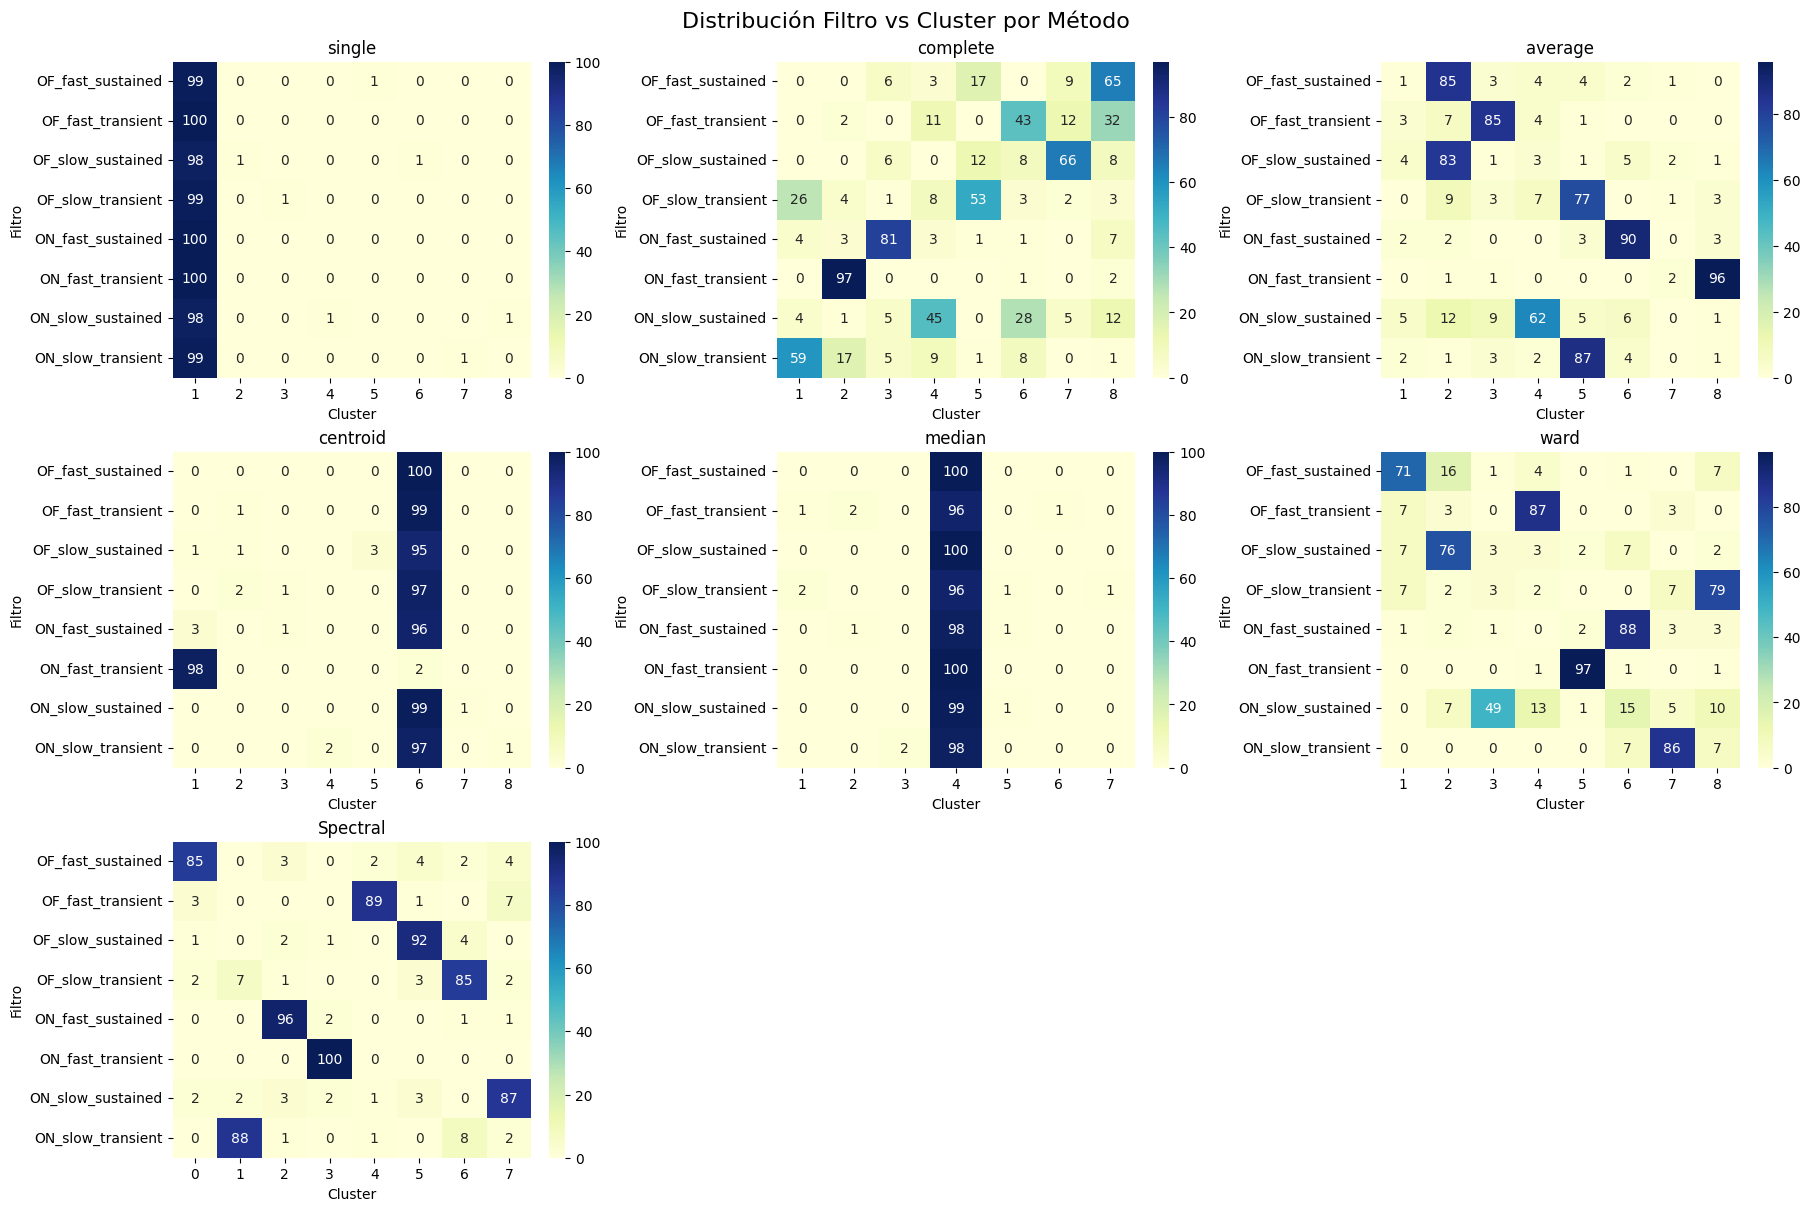

In [48]:
# === MÉTODOS JERÁRQUICOS ===
linkage_methods = ["single", "complete", "average", "centroid", "median", "ward"]
for method in linkage_methods:
    try:
        linked = linkage(Z, method=method) if method == "ward" else linkage(condensed, method=method)
        clusters = fcluster(linked, t=8, criterion="maxclust")

        ari = adjusted_rand_score(true_labels, clusters)
        ami = adjusted_mutual_info_score(true_labels, clusters)
        fmi = fowlkes_mallows_score(true_labels, clusters)
        completeness = completeness_score(true_labels, clusters)

        results.append({
            "Method": f"Hier-{method}",
            "ARI": ari,
            "AMI": ami,
            "FMI": fmi,
            "Completeness": completeness
        })

        clusterings[f"{method}"] = clusters

    except Exception as e:
        print(f"❌ Error con {method}: {e}")

# === CLUSTERING ESPECTRAL ===
try:
    spectral = SpectralClustering(n_clusters=8, affinity='precomputed', random_state=0)
    affinity_matrix = np.exp(-dist_matrix / dist_matrix.std())  # Similaridad basada en distancia
    clusters_spec = spectral.fit_predict(affinity_matrix)

    ari = adjusted_rand_score(true_labels, clusters_spec)
    ami = adjusted_mutual_info_score(true_labels, clusters_spec)
    fmi = fowlkes_mallows_score(true_labels, clusters_spec)
    completeness = completeness_score(true_labels, clusters_spec)

    results.append({
        "Method": "Spectral",
        "ARI": ari,
        "AMI": ami,
        "FMI": fmi,
        "Completeness": completeness
    })

    clusterings["Spectral"] = clusters_spec

except Exception as e:
    print(f"❌ Error en clustering espectral: {e}")

# === MOSTRAR METRICAS ===
results_df = pd.DataFrame(results)
print("\n✅ Resultados de Clustering:\n")
print(results_df)

# === MOSTRAR HEATMAPS ===
heatmap_cluster_vs_filter_multi(df["filter"], clusterings, n_cols=3, normalize=False)